# Google Drive Preliminaries

In [ ]:
#-- "Mount" Google Drive to access data and save files/images --#
# NOTE: If running locally, comment out this cell and change the basePath accordingly
# Reference: https://stackoverflow.com/questions/49031798/when-i-use-google-colaboratory-how-to-save-image-weights-in-my-google-drive
from google.colab import drive
drive.mount('/content/gdrive')

# You will be asked to sign into a Google account and give GoogleColab access

Mounted at /content/gdrive


In [ ]:
# To check that mounting worked, uncomment and run the following. You should see the contents of the directory listed.
! ls '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Data/'

Ato4l_lepFilter_13TeV_filtered.h5
background_for_training.h5
BlackBox_background_mix.h5
hChToTauNu_13TeV_PU20_filtered.h5
hToTauTau_13TeV_PU20_filtered.h5
leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5


In [ ]:
sigAliasList    = ['sig_A', 'sig_h0', 'sig_hch', 'sig_LQ']
sigFilenameList = ['Ato4l_lepFilter_13TeV_filtered.h5', 'hToTauTau_13TeV_PU20_filtered.h5', 'hChToTauNu_13TeV_PU20_filtered.h5', 'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5']

In [ ]:
#-- Set base directory and data directory path --#
basePath   = '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/'
dataPath   = 'Data/'

bkgPath    = basePath+dataPath+'background_for_training.h5'
sigPathList = []
for x in sigFilenameList:
  sigPathList.append(basePath+dataPath+x)

# Import libraries

We'll eventually be using the PyOT library to compute Wasserstein distances for now (see [here](https://pythonot.github.io/index.html)).

In [ ]:
!pip install POT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.0/790.0 kB 6.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
from numpy.random import RandomState
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import h5py
import ot
from numpy.random import Generator, PCG64
from sklearn import metrics
import itertools

/usr/local/lib/python3.10/dist-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


# Functions

In [ ]:
%cd /content/gdrive/My Drive/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/
%run centralFunctions.ipynb

/content/gdrive/My Drive/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge


# Loading Data

In [ ]:
dataDict = {}
dataDict['bkg'] = h5py.File(bkgPath, 'r')

for i in range(len(sigAliasList)):
  alias   = sigAliasList[i]
  sigPath = sigPathList[i]
  dataDict[alias] = h5py.File(sigPath, 'r')

In [ ]:
print("Background Keys in file (f_bkg := dataDict['bkg']):")
for key in dataDict['bkg'].keys():
  print("  ",key)
  print("      f_bkg[%s]"%key)
  print("           .shape: ", dataDict['bkg'][key].shape)
  print("           .dtype: ", dataDict['bkg'][key].dtype)

for alias in sigAliasList:
  print("")
  print("Signal Keys in file (f_sig := dataDict['%s']):"%alias)
  for key in dataDict[alias].keys():
    print("  ",key)
    print("      f_sig[%s]"%key)
    print("           .shape: ", dataDict[alias][key].shape)
    print("           .dtype: ", dataDict[alias][key].dtype)

Background Keys in file (f_bkg := dataDict['bkg']):
   Particles
      f_bkg[Particles]
           .shape:  (13451915, 19, 4)
           .dtype:  float64
   Particles_Classes
      f_bkg[Particles_Classes]
           .shape:  (4,)
           .dtype:  |S16
   Particles_Names
      f_bkg[Particles_Names]
           .shape:  (4,)
           .dtype:  |S5

Signal Keys in file (f_sig := dataDict['sig_A']):
   Particles
      f_sig[Particles]
           .shape:  (55969, 19, 4)
           .dtype:  float64
   Particles_Classes
      f_sig[Particles_Classes]
           .shape:  (4,)
           .dtype:  |S16
   Particles_Names
      f_sig[Particles_Names]
           .shape:  (4,)
           .dtype:  |S5

Signal Keys in file (f_sig := dataDict['sig_h0']):
   Particles
      f_sig[Particles]
           .shape:  (691283, 19, 4)
           .dtype:  float64
   Particles_Classes
      f_sig[Particles_Classes]
           .shape:  (388,)
           .dtype:  |S16
   Particles_Names
      f_sig[Particles_N

This indicates that there are 3 datasets in each file. The first dataset array is the actual data information (see table below).

Let the data be represented by $X$. The information for the $i^{\rm th}$ event is given by $X[i, :, :]$. This is the "face" of the 3D table below. The vertical axis on the "face" is 19 dimensional (${\rm MET}, (e/ \gamma)_i, \mu_j, {\rm jet}_k$ where $i, j = 1, ..., 4$ and $k=1, ..., 10$). The horizontal axis is 4 dimensional. It contains the $p_{\rm T}, \eta, \phi$ information as well as the class information (1, 2, 3 and 4 for MET, electron, muon and jet, respectively).

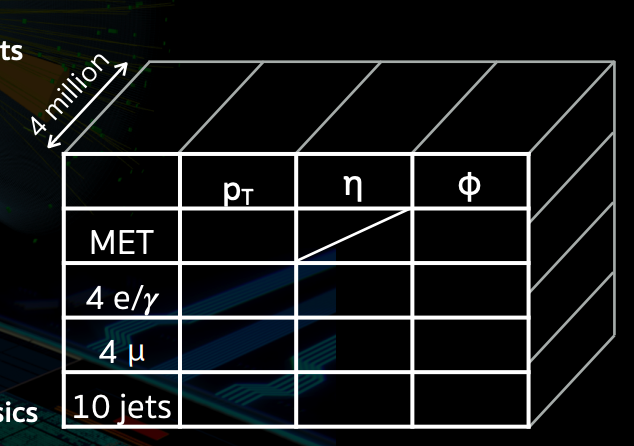

**Description from [the paper](https://www.nature.com/articles/s41597-022-01187-8)**:


*The data records are provided in Hierarchical Data Format version 5 (HDF5), and contain 3 datasets: “Particles”, “Particles_Classes” and “Particles_Names.*

*The dataset “Particles” has a shape (N, 19, 4), where N is the number of events listed for each sample in Table 1. The second index runs over the different physics objects in the events: MET, 4 electrons, 4 muons, 10 jets. Its cardinality (19) is the maximum number of objects per event. If fewer objects are present, the event is zero padded in such a way that the 1st, 5th, and 9th positions correspond to the highest-pT electron, muon, and jet, respectively.*

*The last index (with cardinality 4) runs over the three features describing each physics object and a particle type index, which is equal to 1, 2, 3 and 4 for MET, electron, muon and jet, respectively.*

*The information of which particle kind corresponds to which index value is contained in the “Particle_Classes” dataset, in the form of a single-entry array of strings. Zero padding is done inclusively, e.g. for zero-padded particles the particle type index is set to zero. The features are ordered as described in the “Particles_Names” dataset: pT, η, ϕ.*

*The blackbox sample includes an additional dataset (“EvtId”) with dimension (N), containing an event ID which allows us to match each event to its ground truth (signal or background)."*


$
\space
$

---

$
\space
$


Therefore, the event data we will use is has the shape (N, 19, 3). Where the $i^{th}$ event can be accessed via

```
EventData[i,:,:]
```
And will have shape (19,3). This event could be flattened to represent a point in 19*3 dimensional space. However, it's probably more natural to think of each event as being a collection of 19 particles living in 3D space. Note that events are zero-padded. So a non-existent particle lives at the origin in this 3D space.

In [ ]:
print("Event 0 Raw data:")
print(dataDict['bkg']['Particles'][0, :, :])
print("")
print("Event 0 processed:")
print(dataDict['bkg']['Particles'][0, :, 0:3])
print("")
print("Event 0 particle labels:")
print(dataDict['bkg']['Particles'][0, :, -1])

Event 0 Raw data:
[[27.41296387  0.         -2.0499022   1.        ]
 [24.20996857  1.63350999 -0.10349621  2.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]

Event 0 pro

So background event 0 contains one MET, no electrons, one muon, and one jet.

In [ ]:
print("Particles_Classes: ")
for i in range(4):
  print(dataDict['bkg']["Particles_Classes"][i])
print("")

print("Particles_Names: ")
for i in range(4):
  print(dataDict['bkg']["Particles_Names"][i])

Particles_Classes: 
b'MET_class_1'
b'Four_Ele_class_2'
b'Four_Mu_class_3'
b'Ten_Jet_class_4'

Particles_Names: 
b'Pt'
b'Eta'
b'Phi'
b'Class'


# Data Planing Stage

## Entire range of p_T

The first thing that we need to do is the "plane" the data to see what information we can extract out of the data if the total p_t is fixed. To do this, we split the events into 100 bins first(roughly in increments of 50 GeV)

In [ ]:
bkg_data = dataDict['bkg']['Particles'][:, :, 0:3]

In [ ]:
total_p_T_per_event = np.sum(bkg_data[:, :, 0], axis=1)

bins = np.arange(0, 4500, 15)

nevents = 5

OTSCHEME = {}

OTSCHEME['normPT'] = True
OTSCHEME['balanced'] = True
OTSCHEME['noZeroPad'] = False
OTSCHEME['individualOT'] = False

scoreDict = {}
scoreDict['CBB'] = []
scoreDict['wBB'] = []

for i in range (len(bins) - 1):
  lower_bound = bins[i]
  upper_bound = bins[i + 1]

  # Create a mask for the events that fall into the current bin
  mask = (total_p_T_per_event >= lower_bound) & (total_p_T_per_event < upper_bound)

  # Extract the events in the current bin using the mask
  events_in_bin = bkg_data[mask]

  if len(events_in_bin) < nevents:
    continue

  random_state = Generator(PCG64(123))
  bkg_1 = randomDataSample(events_in_bin, nevents, random_state)
  random_state = Generator(PCG64(456))
  bkg_2 = randomDataSample(events_in_bin, nevents, random_state)

  cost_matrix, anomoly_score = calcOTDistance(bkg_1, bkg_2, OTSCHEME, '2D')

  scoreDict['wBB'].extend(anomoly_score)

  del bkg_1
  del bkg_2
  del mask
  del events_in_bin
  del cost_matrix
  del anomoly_score

In [ ]:
# # Extract the values from scoreDict
# wBB_values = scoreDict['wBB']

# # Create the histogram
# plt.hist(wBB_values, bins=50, edgecolor='black')  # You can adjust the number of bins

# # Add labels and title (optional)
# plt.xlabel('Values')
# plt.ylabel('Frequency')
# plt.title('Histogram of wBB Values')

# # Set the y-axis to log scale
# plt.yscale('log')

# # Display the plot
# plt.show()

In [ ]:
signal_data = {}
for alias in sigAliasList:
  signal_data[alias] = dataDict[alias]['Particles'][:,:,0:3]

In [ ]:
for alias in sigAliasList:
  sig_total_p_T_per_event = np.sum(signal_data[alias][:,:,0],axis = 1);
  scoreDict['CBB'+alias] = []
  scoreDict['wBB'+alias] = []

  for i in range (len(bins) - 1):
    lower_bound = bins[i]
    upper_bound = bins[i + 1]

    mask_bkg = (total_p_T_per_event >= lower_bound) & (total_p_T_per_event < upper_bound)

    mask_sig = (sig_total_p_T_per_event >= lower_bound) & (sig_total_p_T_per_event < upper_bound)

    bkg_events_in_bin = bkg_data[mask_bkg]

    sig_events_in_bin = signal_data[alias][mask_sig]

    if len(bkg_events_in_bin) < nevents or len(sig_events_in_bin) < nevents:
      continue

    random_state = Generator(PCG64(123))
    bkg_samples = randomDataSample(bkg_events_in_bin, nevents, random_state)
    sig_samples = randomDataSample(sig_events_in_bin, nevents, random_state)

    cost_matrix, anomoly_score = calcOTDistance(bkg_samples, sig_samples, OTSCHEME, '2D')

    scoreDict['wBB' + alias].extend(anomoly_score)

    del bkg_events_in_bin
    del sig_events_in_bin

  del sig_total_p_T_per_event

In [ ]:
sig_A = scoreDict['wBBsig_A']
sig_LQ = scoreDict['wBBsig_LQ']
sig_h0 = scoreDict['wBBsig_h0']
sig_hch = scoreDict['wBBsig_hch']

# plt.hist(sig_A, bins=50, edgecolor='red',facecolor='none', linewidth=0.1,label='A anomoly score')
# plt.hist(sig_LQ, bins=50, edgecolor='yellow',facecolor='none', linewidth=0.1,label='LQ anomoly score')
# plt.hist(sig_h0, bins=50, edgecolor='green',facecolor='none', linewidth=0.1,label='h0 anomoly score')
# plt.hist(sig_hch, bins=50, edgecolor='blue', facecolor='none', linewidth=0.1,label='h+- anomoly score')

# # Set the y-axis to log scale
# plt.yscale('log')

# # Add labels and title (optional)
# plt.xlabel('Values')
# plt.ylabel('Frequency')

# # Add a legend to label the histograms
# plt.legend(loc='upper right')

# # Display the plot
# plt.show()

In [ ]:
# A_hist_values, bin_edges = np.histogram(sig_A, bins=50)
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# # Plot the bin values
# plt.plot(bin_centers, A_hist_values, label = 'A')

# LQ_hist_values, bin_edges = np.histogram(sig_LQ, bins=50)
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# plt.plot(bin_centers, LQ_hist_values, label = 'LQ')

# h0_hist_values, bin_edges = np.histogram(sig_h0, bins=50)
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# plt.plot(bin_centers, h0_hist_values, label = 'h0')

# hch_hist_values, bin_edges = np.histogram(sig_hch, bins=50)
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# plt.plot(bin_centers, hch_hist_values, label = 'h+-')

# wBB_values = scoreDict['wBB']
# hist_values, bin_edges = np.histogram(wBB_values, bins=50)
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# plt.plot(bin_centers, hist_values, color = 'black', label = 'Background')

# # Set the y-axis to log scale
# plt.yscale('log')

# # Add labels and title (optional)
# plt.xlabel('Values')
# plt.ylabel('Frequency')
# plt.legend(loc='upper right')

# plt.show()

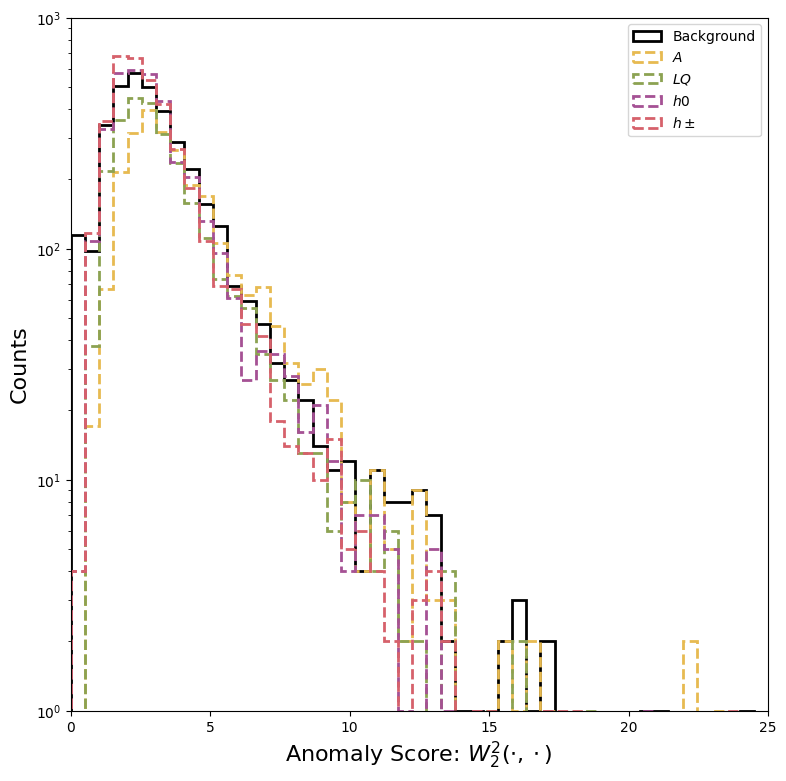

In [ ]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 25)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1000)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 50
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$LQ$', r'$h0$', r'$h\pm$']

score_sig_list = []

score_sig_list.append(np.asarray(sig_A))
score_sig_list.append(np.asarray(sig_LQ))
score_sig_list.append(np.asarray(sig_h0))
score_sig_list.append(np.asarray(sig_hch))

plotScoreHists(scoreDict['wBB'], score_sig_list, plotArgDict)



```
# This is formatted as code
```

### ROC Curves and AUCs

<ipython-input-20-c6d9aac1befa>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sig_arr = np.asarray(score_sig_list)


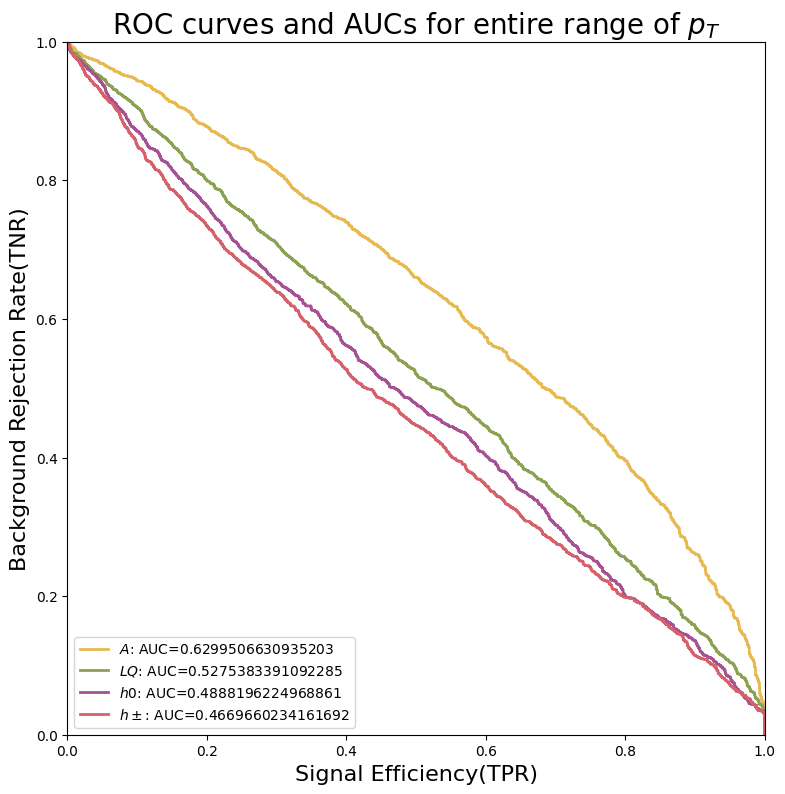

In [ ]:
bkg_arr = np.asarray(scoreDict['wBB'])
sig_arr = np.asarray(score_sig_list)
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(bkg_arr, score_sig_list, SIreg=0.0001)
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 1)
plotArgDict['xLabel']             = r'Signal Efficiency(TPR)'
plotArgDict['yAxisLims']          = (0, 1)
plotArgDict['yLabel']             = r'Background Rejection Rate(TNR)'
plotArgDict['title']              = r'ROC curves and AUCs for entire range of $p_T$'
plotArgDict['nBins']              = 50
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$LQ$', r'$h0$', r'$h\pm$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

## Low p_T range

In [ ]:
bins = np.arange(0, 100, 1)

nevents = 50

OTSCHEME = {}

OTSCHEME['normPT'] = True
OTSCHEME['balanced'] = True
OTSCHEME['noZeroPad'] = False
OTSCHEME['individualOT'] = False

scoreDict['wBB_low_p_T'] = []

for i in range (len(bins) - 1):
  lower_bound = bins[i]
  upper_bound = bins[i + 1]

  # Create a mask for the events that fall into the current bin
  mask = (total_p_T_per_event >= lower_bound) & (total_p_T_per_event < upper_bound)

  # Extract the events in the current bin using the mask
  events_in_bin = bkg_data[mask]

  if len(events_in_bin) < nevents:
    continue

  random_state = Generator(PCG64(123))
  bkg_1 = randomDataSample(events_in_bin, nevents, random_state)
  random_state = Generator(PCG64(456))
  bkg_2 = randomDataSample(events_in_bin, nevents, random_state)

  cost_matrix, anomoly_score = calcOTDistance(bkg_1, bkg_2, OTSCHEME, '2D')

  scoreDict['wBB_low_p_T'].extend(anomoly_score)

  del bkg_1
  del bkg_2
  del mask
  del events_in_bin
  del cost_matrix
  del anomoly_score

In [ ]:
for alias in sigAliasList:
  sig_total_p_T_per_event = np.sum(signal_data[alias][:,:,0],axis = 1);
  scoreDict['wBB'+alias+'low_p_T'] = []

  for i in range (len(bins) - 1):
    lower_bound = bins[i]
    upper_bound = bins[i + 1]

    mask_bkg = (total_p_T_per_event >= lower_bound) & (total_p_T_per_event < upper_bound)

    mask_sig = (sig_total_p_T_per_event >= lower_bound) & (sig_total_p_T_per_event < upper_bound)

    bkg_events_in_bin = bkg_data[mask_bkg]

    sig_events_in_bin = signal_data[alias][mask_sig]

    if len(bkg_events_in_bin) < nevents or len(sig_events_in_bin) < nevents:
      continue

    random_state = Generator(PCG64(123))
    bkg_samples = randomDataSample(bkg_events_in_bin, nevents, random_state)
    sig_samples = randomDataSample(sig_events_in_bin, nevents, random_state)

    cost_matrix, anomoly_score = calcOTDistance(bkg_samples, sig_samples, OTSCHEME, '2D')

    scoreDict['wBB' + alias + 'low_p_T'].extend(anomoly_score)

    del bkg_events_in_bin
    del sig_events_in_bin

  del sig_total_p_T_per_event

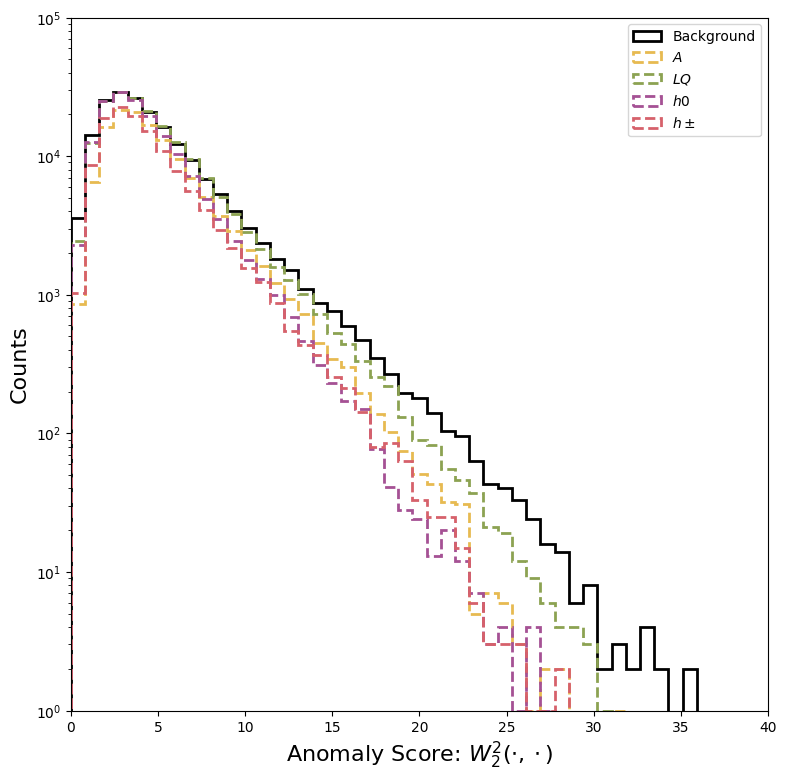

In [ ]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 40)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 100000)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 50
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$LQ$', r'$h0$', r'$h\pm$']

score_sig_list_low_p_T = []

for alias in sigAliasList:
  score_sig_list_low_p_T.append(np.asarray(scoreDict['wBB'+alias+'low_p_T']))

plotScoreHists(scoreDict['wBB_low_p_T'], score_sig_list_low_p_T, plotArgDict)

### ROC Curves and AUCs

<ipython-input-24-d3d235509269>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sig_arr = np.asarray(score_sig_list_low_p_T)


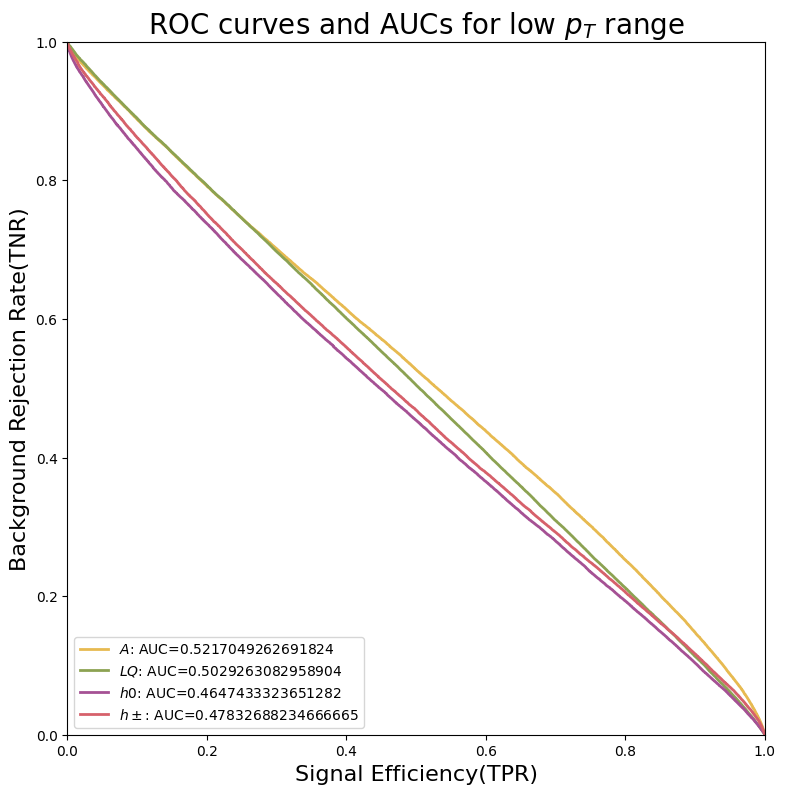

In [ ]:
bkg_arr = np.asarray(scoreDict['wBB_low_p_T'])
sig_arr = np.asarray(score_sig_list_low_p_T)
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(bkg_arr, sig_arr, SIreg=0.0001)
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 1)
plotArgDict['xLabel']             = r'Signal Efficiency(TPR)'
plotArgDict['yAxisLims']          = (0, 1)
plotArgDict['yLabel']             = r'Background Rejection Rate(TNR)'
plotArgDict['title']              = r'ROC curves and AUCs for low $p_T$ range'
plotArgDict['nBins']              = 50
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$LQ$', r'$h0$', r'$h\pm$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

## Mid p_T range

In [ ]:
bins = np.arange(100, 1000, 9)

nevents = 50

OTSCHEME = {}

OTSCHEME['normPT'] = True
OTSCHEME['balanced'] = True
OTSCHEME['noZeroPad'] = False
OTSCHEME['individualOT'] = False

scoreDict['wBB_mid_p_T'] = []

for i in range (len(bins) - 1):
  lower_bound = bins[i]
  upper_bound = bins[i + 1]

  # Create a mask for the events that fall into the current bin
  mask = (total_p_T_per_event >= lower_bound) & (total_p_T_per_event < upper_bound)

  # Extract the events in the current bin using the mask
  events_in_bin = bkg_data[mask]

  if len(events_in_bin) < nevents:
    continue

  random_state = Generator(PCG64(123))
  bkg_1 = randomDataSample(events_in_bin, nevents, random_state)
  random_state = Generator(PCG64(456))
  bkg_2 = randomDataSample(events_in_bin, nevents, random_state)

  cost_matrix, anomoly_score = calcOTDistance(bkg_1, bkg_2, OTSCHEME, '2D')

  scoreDict['wBB_mid_p_T'].extend(anomoly_score)

  del bkg_1
  del bkg_2
  del mask
  del events_in_bin
  del cost_matrix
  del anomoly_score

In [ ]:
for alias in sigAliasList:
  sig_total_p_T_per_event = np.sum(signal_data[alias][:,:,0],axis = 1);
  scoreDict['wBB'+alias+'mid_p_T'] = []

  for i in range (len(bins) - 1):
    lower_bound = bins[i]
    upper_bound = bins[i + 1]

    mask_bkg = (total_p_T_per_event >= lower_bound) & (total_p_T_per_event < upper_bound)

    mask_sig = (sig_total_p_T_per_event >= lower_bound) & (sig_total_p_T_per_event < upper_bound)

    bkg_events_in_bin = bkg_data[mask_bkg]

    sig_events_in_bin = signal_data[alias][mask_sig]

    if len(bkg_events_in_bin) < nevents or len(sig_events_in_bin) < nevents:
      continue

    random_state = Generator(PCG64(123))
    bkg_samples = randomDataSample(bkg_events_in_bin, nevents, random_state)
    sig_samples = randomDataSample(sig_events_in_bin, nevents, random_state)

    cost_matrix, anomoly_score = calcOTDistance(bkg_samples, sig_samples, OTSCHEME, '2D')

    scoreDict['wBB' + alias + 'mid_p_T'].extend(anomoly_score)

    del bkg_events_in_bin
    del sig_events_in_bin

  del sig_total_p_T_per_event

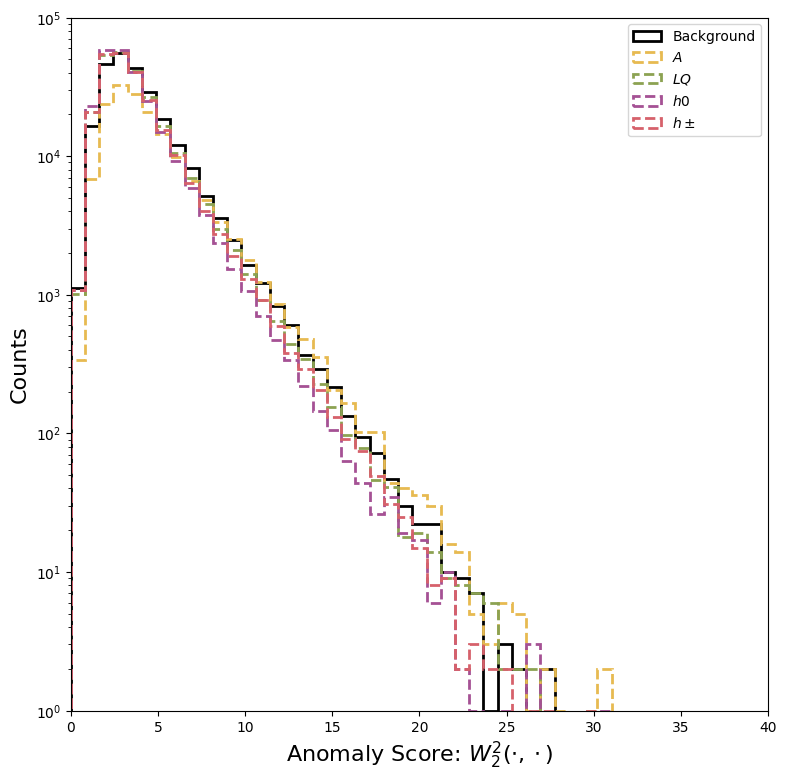

In [ ]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 40)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 100000)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 50
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$LQ$', r'$h0$', r'$h\pm$']

score_sig_list_mid_p_T = []

for alias in sigAliasList:
  score_sig_list_mid_p_T.append(np.asarray(scoreDict['wBB'+alias+'mid_p_T']))

plotScoreHists(scoreDict['wBB_mid_p_T'], score_sig_list_mid_p_T, plotArgDict)

### ROC Curves and AUCs

<ipython-input-28-5e1f029e7fe2>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sig_arr = np.asarray(score_sig_list_mid_p_T)


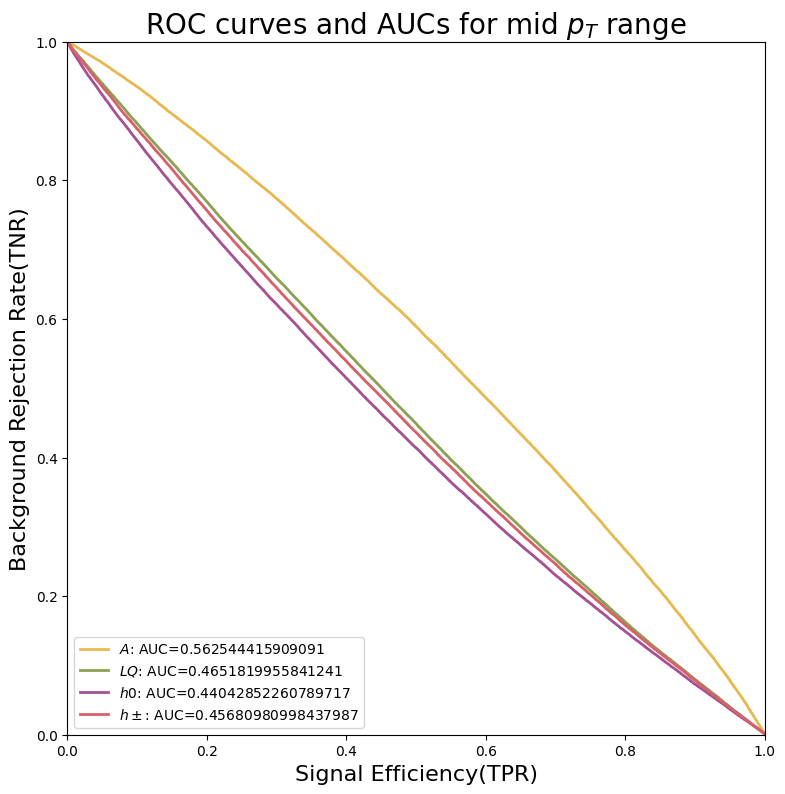

In [ ]:
bkg_arr = np.asarray(scoreDict['wBB_mid_p_T'])
sig_arr = np.asarray(score_sig_list_mid_p_T)
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(bkg_arr, sig_arr, SIreg=0.0001)
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 1)
plotArgDict['xLabel']             = r'Signal Efficiency(TPR)'
plotArgDict['yAxisLims']          = (0, 1)
plotArgDict['yLabel']             = r'Background Rejection Rate(TNR)'
plotArgDict['title']              = r'ROC curves and AUCs for mid $p_T$ range'
plotArgDict['nBins']              = 50
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$LQ$', r'$h0$', r'$h\pm$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

## High p_T Range

In [ ]:
bins = np.arange(1000, 2000, 10)

nevents = 10

OTSCHEME = {}

OTSCHEME['normPT'] = True
OTSCHEME['balanced'] = True
OTSCHEME['noZeroPad'] = False
OTSCHEME['individualOT'] = False

scoreDict['wBB_high_p_T'] = []

for i in range (len(bins) - 1):
  lower_bound = bins[i]
  upper_bound = bins[i + 1]

  # Create a mask for the events that fall into the current bin
  mask = (total_p_T_per_event >= lower_bound) & (total_p_T_per_event < upper_bound)

  # Extract the events in the current bin using the mask
  events_in_bin = bkg_data[mask]

  if len(events_in_bin) < nevents:
    continue

  random_state = Generator(PCG64(123))
  bkg_1 = randomDataSample(events_in_bin, nevents, random_state)
  random_state = Generator(PCG64(456))
  bkg_2 = randomDataSample(events_in_bin, nevents, random_state)

  cost_matrix, anomoly_score = calcOTDistance(bkg_1, bkg_2, OTSCHEME, '2D')

  scoreDict['wBB_high_p_T'].extend(anomoly_score)

  del bkg_1
  del bkg_2
  del mask
  del events_in_bin
  del cost_matrix
  del anomoly_score

In [ ]:
for alias in sigAliasList:
  sig_total_p_T_per_event = np.sum(signal_data[alias][:,:,0],axis = 1);
  scoreDict['wBB'+alias+'high_p_T'] = []

  for i in range (len(bins) - 1):
    lower_bound = bins[i]
    upper_bound = bins[i + 1]

    mask_bkg = (total_p_T_per_event >= lower_bound) & (total_p_T_per_event < upper_bound)

    mask_sig = (sig_total_p_T_per_event >= lower_bound) & (sig_total_p_T_per_event < upper_bound)

    bkg_events_in_bin = bkg_data[mask_bkg]

    sig_events_in_bin = signal_data[alias][mask_sig]

    if len(bkg_events_in_bin) < nevents or len(sig_events_in_bin) < nevents:
      continue

    random_state = Generator(PCG64(123))
    bkg_samples = randomDataSample(bkg_events_in_bin, nevents, random_state)
    sig_samples = randomDataSample(sig_events_in_bin, nevents, random_state)

    cost_matrix, anomoly_score = calcOTDistance(bkg_samples, sig_samples, OTSCHEME, '2D')

    scoreDict['wBB' + alias + 'high_p_T'].extend(anomoly_score)

    del bkg_events_in_bin
    del sig_events_in_bin

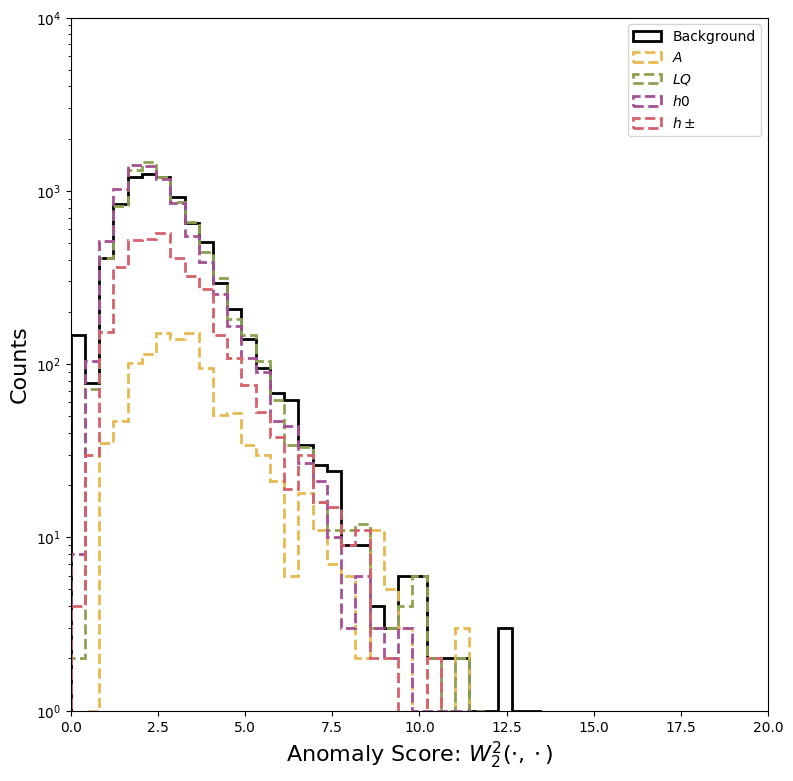

In [ ]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 20)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 10000)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 50
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$LQ$', r'$h0$', r'$h\pm$']

score_sig_list_high_p_T = []

for alias in sigAliasList:
  score_sig_list_high_p_T.append(np.asarray(scoreDict['wBB'+alias+'high_p_T']))

plotScoreHists(scoreDict['wBB_high_p_T'], score_sig_list_high_p_T, plotArgDict)

### ROC Curves and AUCs

<ipython-input-32-3d1c11424968>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sig_arr = np.asarray(score_sig_list_high_p_T)


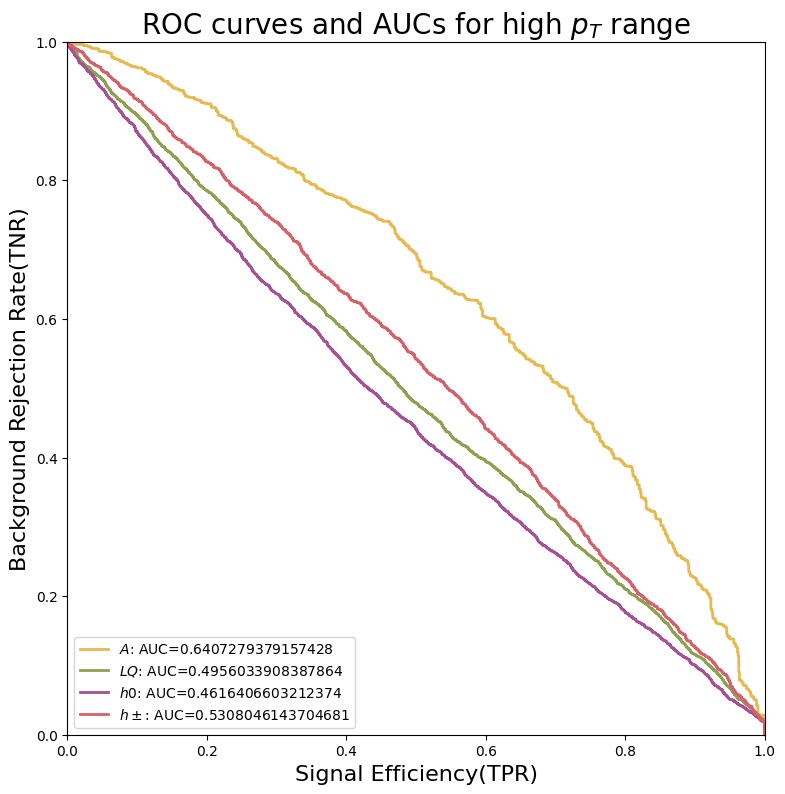

In [ ]:
bkg_arr = np.asarray(scoreDict['wBB_high_p_T'])
sig_arr = np.asarray(score_sig_list_high_p_T)
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(bkg_arr, sig_arr, SIreg=0.0001)
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 1)
plotArgDict['xLabel']             = r'Signal Efficiency(TPR)'
plotArgDict['yAxisLims']          = (0, 1)
plotArgDict['yLabel']             = r'Background Rejection Rate(TNR)'
plotArgDict['title']              = r'ROC curves and AUCs for high $p_T$ range'
plotArgDict['nBins']              = 50
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$LQ$', r'$h0$', r'$h\pm$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

## Very high p_T range

In [ ]:
bins = np.arange(2000, 4000, 20)

nevents = 3

OTSCHEME = {}

OTSCHEME['normPT'] = True
OTSCHEME['balanced'] = True
OTSCHEME['noZeroPad'] = False
OTSCHEME['individualOT'] = False

scoreDict['wBB_very_high_p_T'] = []

for i in range (len(bins) - 1):
  lower_bound = bins[i]
  upper_bound = bins[i + 1]

  # Create a mask for the events that fall into the current bin
  mask = (total_p_T_per_event >= lower_bound) & (total_p_T_per_event < upper_bound)

  # Extract the events in the current bin using the mask
  events_in_bin = bkg_data[mask]

  if len(events_in_bin) < nevents:
    continue

  random_state = Generator(PCG64(123))
  bkg_1 = randomDataSample(events_in_bin, nevents, random_state)
  random_state = Generator(PCG64(456))
  bkg_2 = randomDataSample(events_in_bin, nevents, random_state)

  cost_matrix, anomoly_score = calcOTDistance(bkg_1, bkg_2, OTSCHEME, '2D')

  scoreDict['wBB_very_high_p_T'].extend(anomoly_score)

  del bkg_1
  del bkg_2
  del mask
  del events_in_bin
  del cost_matrix
  del anomoly_score

In [ ]:
for alias in sigAliasList:
  sig_total_p_T_per_event = np.sum(signal_data[alias][:,:,0],axis = 1);
  scoreDict['wBB'+alias+'very_high_p_T'] = []

  for i in range (len(bins) - 1):
    lower_bound = bins[i]
    upper_bound = bins[i + 1]

    mask_bkg = (total_p_T_per_event >= lower_bound) & (total_p_T_per_event < upper_bound)

    mask_sig = (sig_total_p_T_per_event >= lower_bound) & (sig_total_p_T_per_event < upper_bound)

    bkg_events_in_bin = bkg_data[mask_bkg]

    sig_events_in_bin = signal_data[alias][mask_sig]

    if len(bkg_events_in_bin) < nevents or len(sig_events_in_bin) < nevents:
      continue

    random_state = Generator(PCG64(123))
    bkg_samples = randomDataSample(bkg_events_in_bin, nevents, random_state)
    sig_samples = randomDataSample(sig_events_in_bin, nevents, random_state)

    cost_matrix, anomoly_score = calcOTDistance(bkg_samples, sig_samples, OTSCHEME, '2D')

    scoreDict['wBB' + alias + 'very_high_p_T'].extend(anomoly_score)

    del bkg_events_in_bin
    del sig_events_in_bin

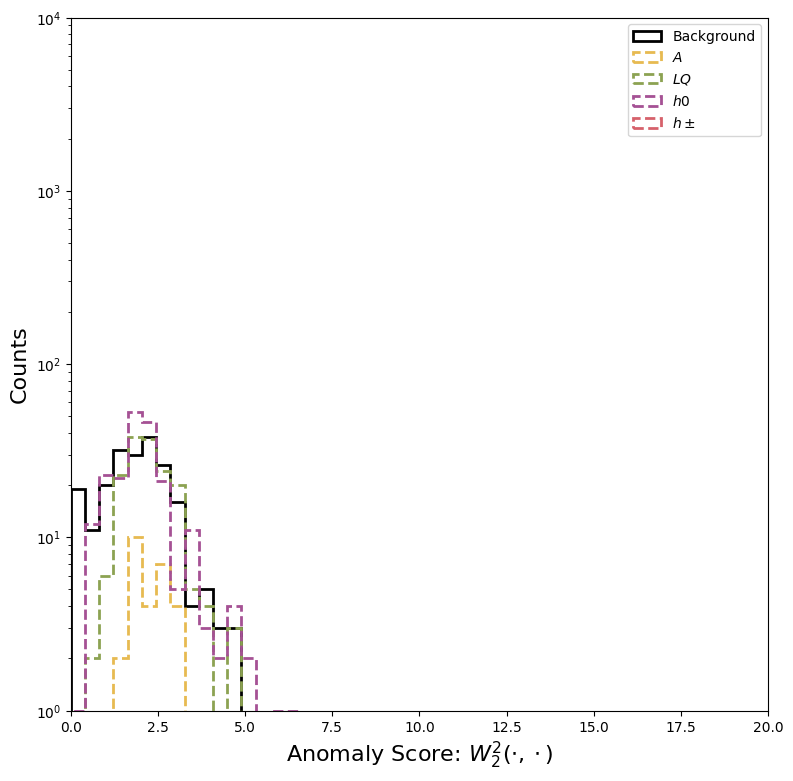

In [ ]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 20)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 10000)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 50
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$LQ$', r'$h0$', r'$h\pm$']

score_sig_list_very_high_p_T = []

for alias in sigAliasList:
  score_sig_list_very_high_p_T.append(scoreDict['wBB'+alias+'very_high_p_T'])

plotScoreHists(scoreDict['wBB_very_high_p_T'], score_sig_list_very_high_p_T, plotArgDict)

### ROC curves and AUCs

The ROC curves and AUCs can not be calculate for this case as there are almost no events in each given bin in the very high range of p_T

# Machine Learning Classification using SVM

## Entire Range of p_T

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
background_scores = scoreDict['wBB']
signal_scores = scoreDict['wBBsig_A'] + scoreDict['wBBsig_h0'] + scoreDict['wBBsig_hch'] + scoreDict['wBBsig_LQ']

np.random.shuffle(background_scores)
np.random.shuffle(signal_scores)

bkg_indicator = np.zeros(len(background_scores))
sig_indicator = np.ones(len(signal_scores))

bkg_x_train, bkg_x_test, bkg_y_train, bkg_y_test = train_test_split(background_scores, bkg_indicator, test_size=0.25, random_state=123)
bkg_x_train, bkg_x_test = np.array(bkg_x_train).reshape(-1, 1), np.array(bkg_x_test).reshape(-1, 1)

sig_x_train, sig_x_test, sig_y_train, sig_y_test = train_test_split(signal_scores, sig_indicator, test_size=0.25, random_state=123)
sig_x_train, sig_x_test = np.array(sig_x_train).reshape(-1, 1), np.array(sig_x_test).reshape(-1, 1)

x_train = np.concatenate((bkg_x_train,sig_x_train), axis = 0)
y_train = np.concatenate((bkg_y_train, sig_y_train))

x_test = np.concatenate((bkg_x_test, sig_x_test), axis = 0)
y_test = np.concatenate((bkg_y_test, sig_y_test))

# Create the SVM with RBF kernel
clf = SVC(kernel='rbf', probability=True)  # Setting probability=True allows us to call predict_proba later

# Train the SVM
clf.fit(x_train, y_train)

# Get predicted probabilities for the positive class (1 - Signal)
y_prob = clf.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)


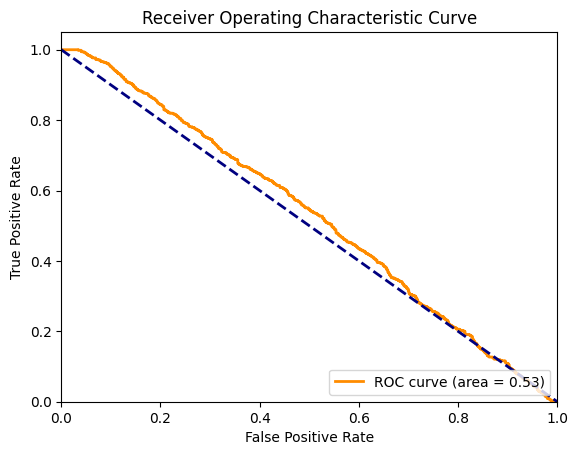

In [ ]:
# Plotting the ROC curve
plt.figure()
lw = 2
plt.plot(1-fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()